In [1]:
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import visualpriors
import subprocess
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import h5py
import os
from src.core.data_types import Dataset
from src.ai.utils import mlp_creator
from src.data.utils import load_run, load_dataset_from_hdf5, select, load_data_from_directory


In [2]:
################################################################################
# Load data                                                                    #
################################################################################
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'noisy_augmented_3x256x256_0.hdf5')
h5py_file = h5py.File(filename, 'r')

In [20]:
################################################################################
# Define network                                                               #
################################################################################
input_size = 8*16*16
output_size = 64*64
decoder = mlp_creator(sizes=[input_size, 2056, 2056, output_size],
                      activation=nn.ReLU,
                      output_activation=None,
                      bias_in_last_layer=False)


In [19]:
i = 0
torch.as_tensor(h5py_file['dataset']['targets'][i], dtype=torch.float32)[:, ::2, ::2].shape

torch.Size([1, 64, 64])

In [21]:
################################################################################
# Take some training steps                                                     #
################################################################################
batch_size = 32
learning_rate = 0.00001
N = 10
total = len(h5py_file['dataset']['observations'])
feature_type = 'normal'
optimizer = torch.optim.Adam(params=decoder.parameters(), lr=learning_rate)
losses = []
for epoch in tqdm(range(N)):
    optimizer.zero_grad()
    sample_indices = np.random.choice(list(range(total)),
                                      size=batch_size)
    observations = [torch.as_tensor(h5py_file['dataset']['observations'][i], dtype=torch.float32) for i in sample_indices]
    targets = [torch.as_tensor(h5py_file['dataset']['targets'][i], dtype=torch.float32)[:, ::2, ::2] for i in sample_indices]
    representation = visualpriors.representation_transform(torch.stack(observations), feature_type, device='cpu')
    predictions = decoder(representation.view(-1, 2048)).view(-1, 64, 64)
    loss = (torch.stack(targets) - predictions).abs().sum()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'epoch {epoch}, loss: {loss.item()}')
observations = None
representation = None
predictions = None
targets = None

 10%|█         | 1/10 [00:04<00:44,  4.92s/it]

epoch 0, loss: 4120011.25


 20%|██        | 2/10 [00:09<00:39,  4.95s/it]

epoch 1, loss: 4114778.0


KeyboardInterrupt: 

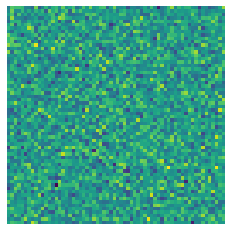

In [22]:
################################################################################
# Predict on real validation images                                            #
################################################################################
output_path = '/tmp/out'
os.makedirs(output_path, exist_ok=True)

validation_runs = [os.path.join(os.environ['DATADIR'], 'line_world_data', 'real', 'raw_data', d, 'raw_data', sd, 'observation') 
                   for d in ['concrete_bluecable', 'concrete_orangecable', 'concrete_whitecable', 'grass_bluecable', 'grass_orangecable']
                   for sd in os.listdir(os.path.join(os.environ['DATADIR'], 'line_world_data', 'real', 'raw_data', d, 'raw_data'))]
fig_counter = 0
for run in validation_runs[0:1]:
    data = load_data_from_directory(run, size=(3,256,256))[1][::20]    
    representation = visualpriors.representation_transform(torch.stack(data), feature_type, device='cpu')
    with torch.no_grad():
        predictions = decoder(representation.view(-1, 2048)).view(-1, 64, 64).detach().numpy()
    for pred in predictions:        
        plt.imshow(pred)
        plt.axis('off')
        plt.savefig(os.path.join(output_path, f'{fig_counter:010d}.jpg'))
        fig_counter += 1


In [8]:
################################################################################
# Create binary dataset with 3x256x256 input and 1x128x128 binary output       #
# input should be in range of -1:1
################################################################################

for group_index in range(3):
    filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'line_world_sim_128x128x3_wp.hdf5')
    h5py_file = h5py.File(filename, 'r')
    amount = 3000
    
    print(f'group: {group_index}')
    observations = h5py_file['dataset']['observations'][group_index*amount:(1+group_index)*amount]
    h5py_file.close()
    
    print('extract binary target images')
    threshold = 0.5
    binary_images = []
    for image in tqdm.tqdm(observations):
        binary_images.append(cv2.threshold(image.mean(axis=0, keepdims=True), 0.5, 1, cv2.THRESH_BINARY)[1])
    binary_images = np.asarray(binary_images)
    
    # ensure not everything is white
    assert binary_images[0].sum() != binary_images[0].shape[1] * binary_images[0].shape[2]
    h5py_file = None
    observations = None
    
    print('augment input image with three color noise')
    noise_augmented_images = []
    size = (3, 256, 256)
    for image in tqdm.tqdm(binary_images):
        image = image.squeeze()
        image = cv2.resize(image, dsize=(size[1], size[2]), interpolation=cv2.INTER_NEAREST)
        new_shape = (*image.shape, 3)
        bg = np.random.uniform(0, 1, size=new_shape)
        fg = np.zeros(new_shape) + np.random.uniform(0, 1)
        three_channel_image = np.stack([image]*3, axis=-1)
        new_img = (-(three_channel_image - 1) * fg + three_channel_image * bg)/2.
        noise_augmented_images.append(new_img.swapaxes(2, 1).swapaxes(1, 0))
        
    noise_augmented_images = np.asarray(noise_augmented_images)
    
    print('write it all away')
    filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'noisy_augmented_wp_3x256x256_{group_index}.hdf5')
    new_h5py_file = h5py.File(filename, 'w')
    h5py_dataset = new_h5py_file.create_group('dataset')
    h5py_dataset['targets'] = binary_images
    h5py_dataset['observations'] = noise_augmented_images
    new_h5py_file.close()

In [19]:
.shape

torch.Size([10, 2048])

tensor(16054.2773, grad_fn=<SumBackward0>)

In [26]:
################################################################################
# Test task networks and detect 'bad' ones                                     #
################################################################################

filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'noisy_augmented_wp_3x256x256_0.hdf5')
h5py_file = h5py.File(filename, 'r')
dataset = Dataset()
dataset.extend(h5py_file['dataset'])
image = dataset.observations[0]


tasks = ['autoencoding', 'depth_euclidean', 'jigsaw', 'reshading', 'colorization', 'edge_occlusion', 'keypoints2d', 'room_layout', 'curvature', 'edge_texture', 'keypoints3d', 'segment_unsup2d', 
'class_object',  'egomotion', 'nonfixated_pose', 'segment_unsup25d',  'class_scene', 'fixated_pose', 'normal', 'segment_semantic', 'denoising', 'inpainting', 'point_matching', 'vanishing_point']

not_working_models = ['colorization', 'reshading']
for feature_type in tasks:
    if feature_type in not_working_models:
        continue
    o_t = TF.to_tensor(TF.resize(image, 256)) * 2 - 1
    o_t = o_t.unsqueeze_(0)

    representation = visualpriors.representation_transform(o_t, feature_type, device='cpu') # phi(o_t) in the diagram below
    print(f'{feature_type}: {representation.shape}')

autoencoding: torch.Size([1, 8, 16, 16])
depth_euclidean: torch.Size([1, 8, 16, 16])
jigsaw: torch.Size([1, 8, 16, 16])
edge_occlusion: torch.Size([1, 8, 16, 16])
keypoints2d: torch.Size([1, 8, 16, 16])
room_layout: torch.Size([1, 8, 16, 16])
curvature: torch.Size([1, 8, 16, 16])
edge_texture: torch.Size([1, 8, 16, 16])
keypoints3d: torch.Size([1, 8, 16, 16])
segment_unsup2d: torch.Size([1, 8, 16, 16])
class_object: torch.Size([1, 8, 16, 16])
egomotion: torch.Size([1, 8, 16, 16])
nonfixated_pose: torch.Size([1, 8, 16, 16])
segment_unsup25d: torch.Size([1, 8, 16, 16])
class_scene: torch.Size([1, 8, 16, 16])
fixated_pose: torch.Size([1, 8, 16, 16])
normal: torch.Size([1, 8, 16, 16])
segment_semantic: torch.Size([1, 8, 16, 16])
denoising: torch.Size([1, 8, 16, 16])
inpainting: torch.Size([1, 8, 16, 16])
point_matching: torch.Size([1, 8, 16, 16])
vanishing_point: torch.Size([1, 8, 16, 16])


In [4]:
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'noisy_augmented_wp_3x256x256_0.hdf5')
h5py_file = h5py.File(filename, 'r')
dataset = Dataset()
dataset.extend(h5py_file['dataset'])
image = dataset.observations[0]

In [9]:

feature_type = 'vanishing_point'
representation = visualpriors.representation_transform(torch.stack(dataset.observations[:10]), feature_type, device='cpu') # phi(o_t) in the diagram below
print(representation.shape)

torch.Size([10, 8, 16, 16])


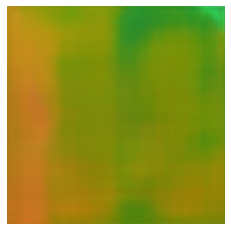

In [22]:
# Test representation on test image

#filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'real', 'validation.hdf5')
#h5py_file = h5py.File(filename, 'r')
#dataset = Dataset()
#dataset.extend(h5py_file['dataset'])
#image = dataset.observations[0]
image = Image.open('/Users/kelchtermans/mount/ubuntu/home/klaas/code/imitation-learning-codebase/experimental_data/line_world_real2/concrete_bluecable/raw_data/20-07-24_11-22-29_joystick/observation/001595582561766.jpg')

o_t = TF.to_tensor(TF.resize(image, 256)) * 2 - 1
o_t = o_t[:3, :, :]
o_t = o_t.unsqueeze_(0)

# predict normals
feature_type = 'normal'
# Transform to normals feature
representation = visualpriors.representation_transform(o_t, feature_type, device='cpu') # phi(o_t) in the diagram below

# Transform to normals feature and then visualize the readout
pred = visualpriors.feature_readout(o_t, feature_type, device='cpu')

# Save it
#TF.to_pil_image(pred[0] / 2. + 0.5).save('test_{}_readout.png'.format(feature_type))
plt.imshow((pred[0] / 2. + 0.5).detach().numpy().swapaxes(0,1).swapaxes(1,2))
plt.axis('off')
plt.show()